In [1]:
import pandas as pd
import numpy as np

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout

from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from tensorflow.keras.optimizers import Adam
from datetime import datetime


from sklearn.preprocessing import MinMaxScaler,OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.metrics import mean_squared_error, r2_score

import shap

In [2]:
#Load dataset into a pandas dataframe
# data = pd.read_csv("../data/Cleaned data/data.csv") 
data = pd.read_csv("data.csv") 

data.dropna(inplace = True)

data.head()

,YEAR,MONTH,DAY,HUMIDITY,WINDSPEED,DATE,TOTALDEMAND,HOLIDAY,MIN,MAX,SOLAR,TEMPAVE,RRP,FORECASTDEMAND,OUTPUT,MONTHDATE,WEEKDAY,WEEKEND
0,2016,1,1,0.656341,15.902439,2016-01-01,6853.633437,2.0,15.3,28.6,32.2,21.95,38.472917,6665.366167,23.465,01-2016,4,0
1,2016,1,2,0.656341,15.902439,2016-01-02,6727.613958,0.0,15.9,26.1,21.7,21.00,36.907292,6236.849955,23.465,01-2016,5,1
2,2016,1,3,0.688837,14.488372,2016-01-03,6616.406076,0.0,17.5,25.6,10.3,21.55,31.997083,6551.924748,23.465,01-2016,6,1
3,2016,1,4,0.679545,22.477273,2016-01-04,7367.750278,0.0,18.2,23.6,6.4,20.90,33.424583,6729.993123,23.465,01-2016,0,0
4,2016,1,5,0.768837,22.581395,2016-01-05,7462.242014,0.0,17.6,20.5,4.4,19.05,33.053958,7333.898202,23.465,01-2016,1,0


In [3]:

df = data.drop(['MIN','MAX','FORECASTDEMAND', 'MONTHDATE','WEEKEND'], axis=1)


df.head()

#print(df.isna().sum())
# Check number of rows in df before join operation
print("Number of rows in df before join operation:", df.shape[0])

Number of rows in df before join operation: 2325


In [4]:
# Onehot Encoding for categorial data (Weekday)


# Select the "WEEKDAY" column and create a new dataframe
weekday_df = df[['WEEKDAY']].reset_index(drop=True)


# Create a one-hot encoder object

encoder = OneHotEncoder(categories='auto')

# Fit and transform the weekday data
weekday_encoded = encoder.fit_transform(df[['WEEKDAY']]).toarray()

# Create a new dataframe with the encoded weekday data
weekday_df_encoded = pd.DataFrame(weekday_encoded, columns=['MON', 'TUE', 'WED', 'THU', 'FRI', 'SAT', 'SUN']).reset_index(drop=True)


#Drop weekday column
df = df.drop(['WEEKDAY'], axis=1)


# Concatenate the original dataframe with the encoded weekday dataframe
df = pd.concat([df.reset_index(drop=True), weekday_df_encoded], axis=1)


df.head()


,YEAR,MONTH,DAY,HUMIDITY,WINDSPEED,DATE,TOTALDEMAND,HOLIDAY,SOLAR,TEMPAVE,RRP,OUTPUT,MON,TUE,WED,THU,FRI,SAT,SUN
0,2016,1,1,0.656341,15.902439,2016-01-01,6853.633437,2.0,32.2,21.95,38.472917,23.465,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,2016,1,2,0.656341,15.902439,2016-01-02,6727.613958,0.0,21.7,21.00,36.907292,23.465,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,2016,1,3,0.688837,14.488372,2016-01-03,6616.406076,0.0,10.3,21.55,31.997083,23.465,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,2016,1,4,0.679545,22.477273,2016-01-04,7367.750278,0.0,6.4,20.90,33.424583,23.465,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2016,1,5,0.768837,22.581395,2016-01-05,7462.242014,0.0,4.4,19.05,33.053958,23.465,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [5]:
# Convert the 'date' column to a datetime object
df['DATE'] = pd.to_datetime(df['DATE'])

# Set 'DATE' as the index
df.set_index('DATE', inplace=True)



In [6]:
# Split the dataset into training and testing sets. 

train_set = np.where((df.index >= datetime(2017, 8, 1)) & (df.index < datetime(2021, 8, 1)))[0]
test_set = np.where(df.index >= datetime(2021, 8, 1))[0]


# identify response variable and predictors

X = df.drop(['TOTALDEMAND'], axis=1).values
y = df['TOTALDEMAND'].values


In [7]:
# Normalize the data


scaler_X = MinMaxScaler(feature_range=(0, 1))
X_train_scaled = scaler_X.fit_transform(X[train_set])
X_test_scaled = scaler_X.transform(X[test_set])

scaler_y = MinMaxScaler(feature_range=(0, 1))
y_train_scaled = scaler_y.fit_transform(y[train_set].reshape(-1, 1)).ravel()
y_test_scaled = scaler_y.transform(y[test_set].reshape(-1, 1)).ravel()

print(X_train_scaled[:5])


[[0.         0.63636364 0.         0.54515261 0.48699955 0.
  0.38782051 0.18563923 0.7116133  0.10793701 0.         1.
  0.         0.         0.         0.         0.        ]
 [0.         0.63636364 0.03333333 0.54515261 0.48699955 0.
  0.38461538 0.18739054 0.64976244 0.10793701 0.         0.
  1.         0.         0.         0.         0.        ]
 [0.         0.63636364 0.06666667 0.67166992 0.28363047 0.
  0.25961538 0.26795096 0.749493   0.10793701 0.         0.
  0.         1.         0.         0.         0.        ]
 [0.         0.63636364 0.1        0.86132831 0.12704281 0.
  0.39423077 0.22767075 0.68692824 0.10793701 0.         0.
  0.         0.         1.         0.         0.        ]
 [0.         0.63636364 0.13333333 0.48354039 0.44853191 0.
  0.41025641 0.2084063  0.55983012 0.10793701 0.         0.
  0.         0.         0.         1.         0.        ]]


In [8]:
#Reshape the data for input to the LSTM model
#(This step is fit the data to 3D tensor format for LSTM model to process the sequential data efficiently 
#and capture any temporal dependencies in the data)

#using sliding window approach to create input-output pairs with timesteps n = 1



X_train = []
y_train = []
for i in range(1, len(X_train_scaled)):
    X_train.append(X_train_scaled[i-1:i, :])
    y_train.append(X_train_scaled[i, 1])
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], X_train.shape[2]))

X_test = []
y_test = []
for i in range(1, len(X_test_scaled)):
    X_test.append(X_test_scaled[i-1:i, :])
    y_test.append(X_test_scaled[i, 1])
X_test, y_test = np.array(X_test), np.array(y_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], X_train.shape[2]))


#X_train.shape[0]
#X_train.shape[1]
#X_train.shape[2]

y_test



array([0.63636364, 0.63636364, 0.63636364, 0.63636364, 0.63636364,
       0.63636364, 0.63636364, 0.63636364, 0.63636364, 0.63636364,
       0.63636364, 0.63636364, 0.63636364, 0.63636364, 0.63636364,
       0.63636364, 0.63636364, 0.63636364, 0.63636364, 0.63636364,
       0.63636364, 0.63636364, 0.63636364, 0.63636364, 0.63636364,
       0.63636364, 0.63636364, 0.63636364, 0.63636364, 0.63636364,
       0.72727273, 0.72727273, 0.72727273, 0.72727273, 0.72727273,
       0.72727273, 0.72727273, 0.72727273, 0.72727273, 0.72727273,
       0.72727273, 0.72727273, 0.72727273, 0.72727273, 0.72727273,
       0.72727273, 0.72727273, 0.72727273, 0.72727273, 0.72727273,
       0.72727273, 0.72727273, 0.72727273, 0.72727273, 0.72727273,
       0.72727273, 0.72727273, 0.72727273, 0.72727273, 0.72727273,
       0.81818182, 0.81818182, 0.81818182, 0.81818182, 0.81818182,
       0.81818182, 0.81818182, 0.81818182, 0.81818182, 0.81818182,
       0.81818182, 0.81818182, 0.81818182, 0.81818182, 0.81818

In [9]:
# Build the LSTM model with three LSTM layers and one Dense output layer


model = Sequential()
model.add(LSTM(units=128, activation='relu', return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(units=64, activation='tanh'))
model.add(Dropout(0.2))
model.add(Dense(units=1, activation='linear'))


optimizer = Adam(learning_rate=0.0001)
model.compile(loss='mean_squared_error', optimizer=optimizer)


In [10]:
# Traing the LSTM model

history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))


Epoch 1/50
45/45 [==============================] - 3s 12ms/step - loss: 0.3297 - val_loss: 0.3158
Epoch 2/50
45/45 [==============================] - 0s 3ms/step - loss: 0.2855 - val_loss: 0.2611
Epoch 3/50
45/45 [==============================] - 0s 4ms/step - loss: 0.2275 - val_loss: 0.1903
Epoch 4/50
45/45 [==============================] - 0s 3ms/step - loss: 0.1591 - val_loss: 0.1226
Epoch 5/50
45/45 [==============================] - 0s 3ms/step - loss: 0.1066 - val_loss: 0.0976
Epoch 6/50
45/45 [==============================] - 0s 4ms/step - loss: 0.0861 - val_loss: 0.0928
Epoch 7/50
45/45 [==============================] - 0s 4ms/step - loss: 0.0790 - val_loss: 0.0853
Epoch 8/50
45/45 [==============================] - 0s 4ms/step - loss: 0.0713 - val_loss: 0.0769
Epoch 9/50
45/45 [==============================] - 0s 3ms/step - loss: 0.0647 - val_loss: 0.0678
Epoch 10/50
45/45 [==============================] - 0s 4ms/step - loss: 0.0584 - val_loss: 0.0588
Epoch 11/50
45/45 

In [11]:
# Make predictions on the test set
y_pred = model.predict(X_test)


11/11 [==============================] - 0s 3ms/step


In [12]:
# Calculate MSE and R-squared

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print('MSE: %.4f' % mse)
print('R-squared: %.4f' % r2)

MSE: 0.0044
R-squared: 0.9587


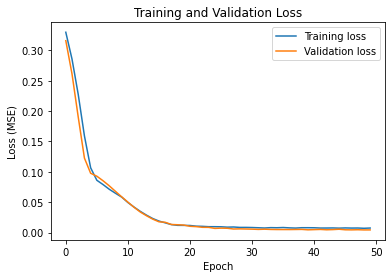

In [13]:


import matplotlib.pyplot as plt 
import matplotlib.dates as mdates
import datetime as dt

# Plot training and validation loss (MSE) for each epoch
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.show()




Plot Accuracy

In [14]:

import matplotlib.pyplot as plt 
import matplotlib.dates as mdates
import datetime as dt



# SHAP

In [15]:
import shap

In [16]:
# # combat shap.DeepExplainer issue (did not work)
# import tensorflow as tf    
# tf.compat.v1.disable_v2_behavior()

In [17]:
# explain the model's predictions using SHAP values

# Please note, error when running shap_values = explainer.shap_values(X_test)
# error: 'TFDeep' object has no attribute 'between_tensors'

explainer = shap.DeepExplainer(model, X_train)
shap_values = explainer.shap_values(X_test)

keras is no longer supported, please use tf.keras instead.
Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


AttributeError: in user code:

    File "C:\Users\c-b-2\anaconda3\lib\site-packages\shap\explainers\_deep\deep_tf.py", line 247, in grad_graph  *
        out = self.model(shap_rAnD)
    File "C:\Users\c-b-2\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler  **
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\c-b-2\anaconda3\lib\site-packages\shap\explainers\_deep\deep_tf.py", line 378, in custom_grad
        out = op_handlers[type_name](self, op, *grads) # we cut off the shap_ prefex before the lookup
    File "C:\Users\c-b-2\anaconda3\lib\site-packages\shap\explainers\_deep\deep_tf.py", line 667, in handler
        return linearity_with_excluded_handler(input_inds, explainer, op, *grads)
    File "C:\Users\c-b-2\anaconda3\lib\site-packages\shap\explainers\_deep\deep_tf.py", line 674, in linearity_with_excluded_handler
        assert not explainer._variable_inputs(op)[i], str(i) + "th input to " + op.name + " cannot vary!"
    File "C:\Users\c-b-2\anaconda3\lib\site-packages\shap\explainers\_deep\deep_tf.py", line 224, in _variable_inputs
        out[i] = t.name in self.between_tensors

    AttributeError: Exception encountered when calling layer 'lstm_1' (type LSTM).
    
    'TFDeep' object has no attribute 'between_tensors'
    
    Call arguments received by layer 'lstm_1' (type LSTM):
      • inputs=tf.Tensor(shape=(2832, 1, 128), dtype=float32)
      • mask=None
      • training=False
      • initial_state=None


In [ ]:
# visualise the first prediction's explanation
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0,:], X_train.iloc[0,:])

In [ ]:
# visualize the training set predictions
shap.force_plot(explainer.expected_value, shap_values, X_train)

In [ ]:
# summarize the effects of all the features
shap.summary_plot(shap_values, X_train)

In [ ]:
shap.summary_plot(shap_values, X_train, plot_type="bar")

### Supporting resources
shap.DeepExplainer
https://shap-lrjball.readthedocs.io/en/latest/generated/shap.DeepExplainer.html

SHAP - Neural networks - Census income classification with Keras
https://shap.readthedocs.io/en/latest/example_notebooks/tabular_examples/neural_networks/Census%20income%20classification%20with%20Keras.html

SHAP - Keras LSTM for IMDB Sentiment Classification
https://shap.readthedocs.io/en/latest/example_notebooks/text_examples/sentiment_analysis/Keras%20LSTM%20for%20IMDB%20Sentiment%20Classification.html

Kaggle - SHAP for LSTM
https://www.kaggle.com/code/phamvanvung/shap-for-lstm/notebook

[forecast][LSTM+SHAP]Applied SHAP on the polynomial equation case with LSTM algorithm
https://medium.com/@sakamoto2000.kim/applied-shap-on-the-polynomial-equation-case-with-lstm-algorithm-7c140d15736b

#### Troubleshooting error when running "shap_values = explainer.shap_values(X_test)", error: 'TFDeep' object has no attribute 'between_tensors'
https://github.com/slundberg/shap/issues/2808

https://www.pythonfixing.com/2021/12/fixed-shap-deepexplainer-with.html

https://stackoverflow.com/questions/66814523/shap-deepexplainer-with-tensorflow-2-4-error